In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Attention
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import random
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

<span style=" font-family: Times New Roman ; font-size: 35px">
    Setting Databases Path <span>

In [2]:
# Data preparation
TRAIN_DIR = "Food/training/"
TEST_DIR= "Food/evaluation/"

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

<span style=" font-family: Times New Roman ; font-size: 35px">
    Settings to CNN </span>

In [4]:
BATCH_SIZE = 16
seeds = 41
im_shape = (250,250)

<span style=" font-family: Times New Roman ; font-size: 35px">
    Resize image </span>

In [14]:
import glob
import cv2

def resize_images(input_folder, output_folder, new_size):
 
    class_folders = glob.glob(os.path.join(input_folder, '*'))

    for class_folder in class_folders:
  
        image_files = glob.glob(os.path.join(class_folder, '*.*'))


        output_class_folder = os.path.join(output_folder, os.path.basename(class_folder))
        os.makedirs(output_class_folder, exist_ok=True)

  
        for img_path in image_files:
            try:
          
                image = cv2.imread(img_path)

        
                resized_image = cv2.resize(image, new_size)

    
                output_path = os.path.join(output_class_folder, os.path.basename(img_path))

   
                cv2.imwrite(output_path, resized_image)

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")

TRAIN_DIR  = "Food/training_1/"
TEST_DIR = "Food/evaluation_1/"
new_size = (250, 250)

resize_images(TRAIN_DIR, TEST_DIR, new_size)
resize_images(TEST_DIR, TEST_DIR, new_size)

<span style=" font-family: Times New Roman ; font-size: 35px">
    Data Preprocessing
</span>

In [5]:
# Subdivision in test/validation
data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255)


# Generator of Train
train_generator = data_generator.flow_from_directory(TRAIN_DIR, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(TRAIN_DIR, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 10641 images belonging to 11 classes.
Found 2656 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.
Classes: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


<span style=" font-family: Times New Roman ; font-size: 35px">
    Data Analysis
</span>

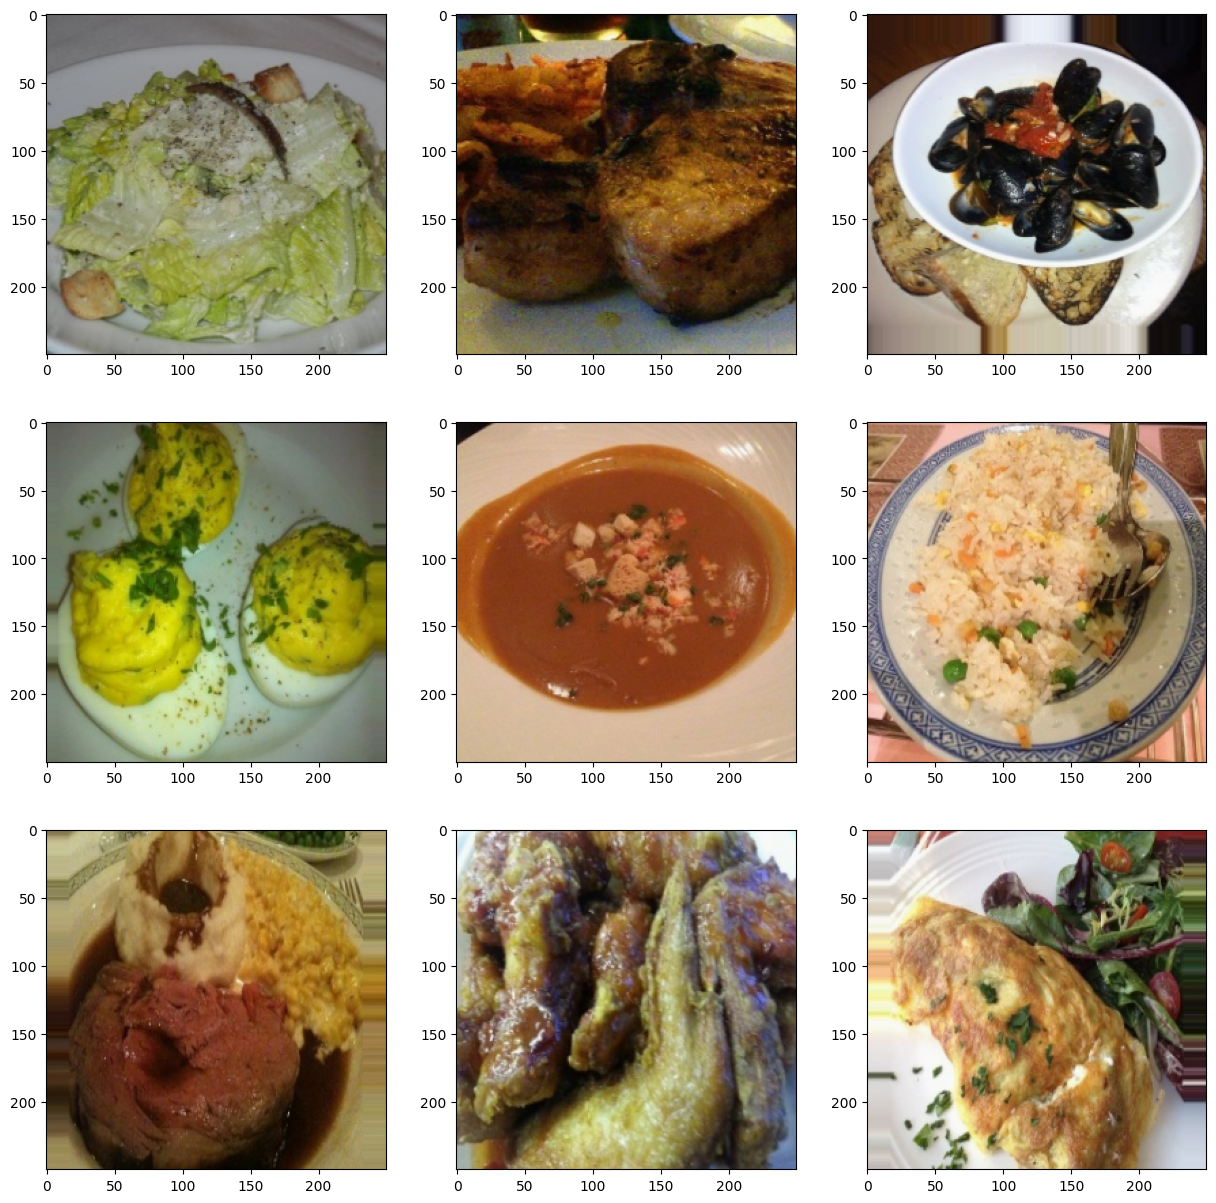

In [17]:
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*250
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [6]:
train = {}
test = {}

path = "Food"

# Make dictionary storing images for each category under train data.
path_train = os.path.join(path, "training")
for i in os.listdir(path_train):
    train[i] = os.listdir(os.path.join(path_train, i))

# Make dictionary storing images for each category under test data.
path_test = os.path.join(path, "evaluation")
for i in os.listdir(path_test):
    test[i] = os.listdir(os.path.join(path_test, i))

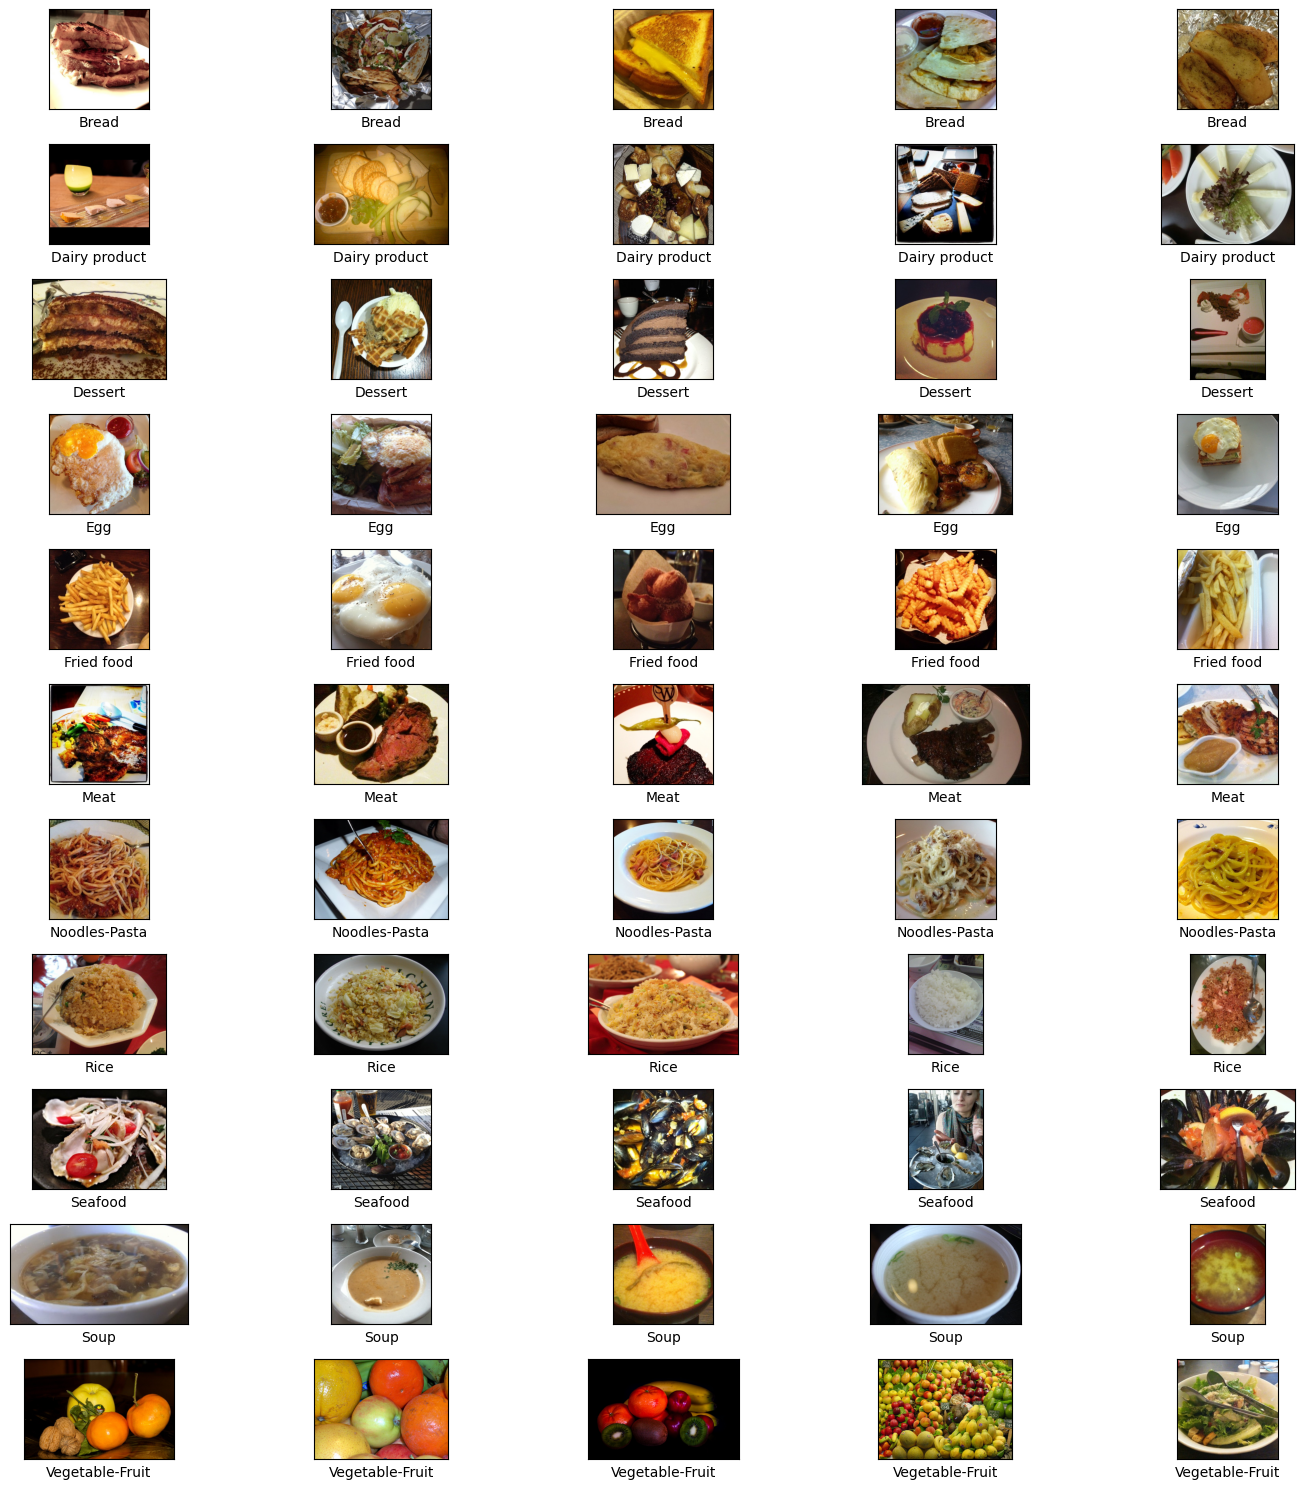

In [7]:
# Randomly display 5 images under each of the 6 categories from the training data.
# You will see different images each time.
from random import sample
import PIL

fig, axs = plt.subplots(len(train.keys()), 5, figsize = (15, 15))
for i, item in enumerate(os.listdir(path_train)):
    images = sample(train[item], 5)
    
    for j, image in enumerate(images):
        img = PIL.Image.open(os.path.join(path_train, item, image))
        axs[i, j].set_xlabel(item, fontsize=10)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = item, xticks = [], yticks = [])
        

fig.tight_layout()
plt.show()

In [8]:
# View the number of images in each of the 6 categories in the training data.
for item in train.keys():
    print(item, len(train[item]))

Bread 1356
Dairy product 573
Dessert 2000
Egg 1313
Fried food 1175
Meat 1774
Noodles-Pasta 587
Rice 376
Seafood 1202
Soup 2000
Vegetable-Fruit 941


C:\Users\HP\AppData\Local\Temp\ipykernel_540\1665619230.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


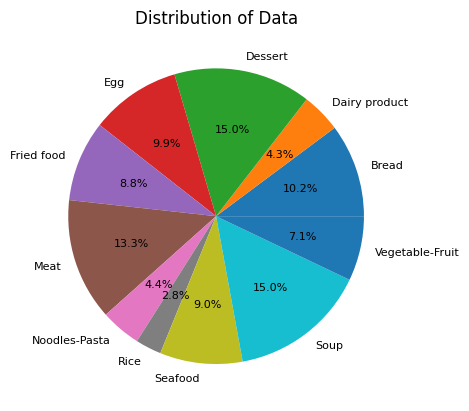

In [11]:
# Make a pie-chart to visualize the percentage contribution of each category.
# This is often useful when you want your dataset to be balanced.
fig, ax = plt.subplots()

sizes = [len(train[item]) for item in train]
labels = list(train.keys())

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
)

ax.set_title("Distribution of Data", fontsize=12)

for text in texts + autotexts:
    text.set_fontsize(8) 

fig.show()

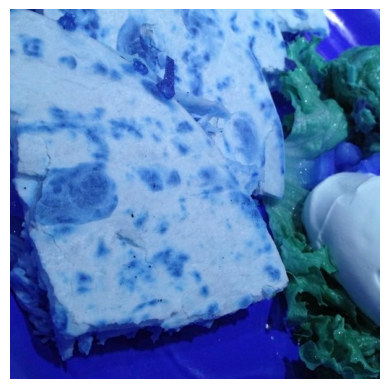

Image Shape: (512, 512, 3)
Image Height: 512
Image Width: 512
Image Dimension: 3
Image Size: 768kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 0


In [12]:
import cv2

plt.figure()
image = cv2.imread("./Food/evaluation/Bread/0.jpg")
plt.imshow(image)
plt.axis('off')
plt.show() 

print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))

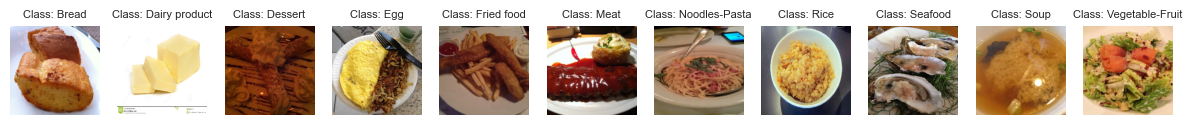

In [79]:
# obtain image and label list from train_generator
# Get category index
class_indices = train_generator.class_indices

# Initializes a dictionary to store the first graph for each category
first_images = {}

# Extract the first graph for each category
for class_name, class_index in class_indices.items():
    # Find the image index for this category
    train_generator.reset()  # Reset the generator to ensure you start from scratch
    found = False
    while not found:
        batch = next(train_generator)
        for index, label in enumerate(batch[1]):
            if label[class_index] == 1:
                first_images[class_name] = batch[0][index]
                found = True
                break


# Displays the first image for each category in a single row
fig, axes = plt.subplots(1, len(first_images), figsize=(15, 3))  # Adjust figsize as needed

for i, (class_name, image) in enumerate(first_images.items()):
    axes[i].imshow(image)
    axes[i].set_title(f'Class: {class_name}', fontsize=8)
    axes[i].axis('off')

plt.show()

<span style=" font-family: Times New Roman ; font-size: 35px">
    Creating CNN to model1
</span>    

In [6]:
def LeNet_model_1(input_shape=(250, 250, 3), num_classes=11, model_name="CNN_Model_01"):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Create the model
model_1 = LeNet_model_1(num_classes=num_classes)

# Display model summary
model_1.summary()


2023-12-12 01:45:33.794561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 01:45:33.812728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-12 01:45:33.813007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 61, 61, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        1

- Define the loss and accuarcy function

In [6]:
from keras import backend as K

def custom_accuracy(y_true, y_pred):
    # Your custom accuracy calculation logic
    correct_predictions = tf.equal(tf.argmax(y_true, 1), tf.argmax(y_pred, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

# Define custom loss function
def custom_loss(y_true, y_pred):
    # Your custom loss calculation logic
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return loss

In [8]:
model_1.compile(loss=custom_loss,
              optimizer=Adam(),
              metrics=[custom_accuracy])

In [9]:
import time
# Record the start time of training
start_time = time.time()

<p><li>CNN_model_1.h5 created</li></p>

In [10]:
epochs = 20

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='CNN_model_1.h5',
        monitor='val_loss', save_best_only=True, verbose=1)
]

#Training
history = model_1.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/20


2023-12-12 01:46:42.270644: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-12 01:46:43.407466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-12 01:46:44.549623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-12 01:46:44.942983: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1dbc5710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-12 01:46:44.943023: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-12-12 01:46:44.970073: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc

663/665 [============================>.] - ETA: 0s - loss: 0.0825 - custom_accuracy: 0.1884
Epoch 1: val_loss improved from inf to 0.07786, saving model to CNN_model_1.h5
665/665 [==============================] - 25s 30ms/step - loss: 0.0825 - custom_accuracy: 0.1888 - val_loss: 0.0779 - val_custom_accuracy: 0.2285
Epoch 2/20
  1/665 [..............................] - ETA: 33s - loss: 0.0625 - custom_accuracy: 0.5625

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


663/665 [============================>.] - ETA: 0s - loss: 0.0764 - custom_accuracy: 0.2656
Epoch 2: val_loss improved from 0.07786 to 0.07406, saving model to CNN_model_1.h5
665/665 [==============================] - 18s 27ms/step - loss: 0.0764 - custom_accuracy: 0.2654 - val_loss: 0.0741 - val_custom_accuracy: 0.3050
Epoch 3/20
663/665 [============================>.] - ETA: 0s - loss: 0.0710 - custom_accuracy: 0.3445
Epoch 3: val_loss improved from 0.07406 to 0.07156, saving model to CNN_model_1.h5
665/665 [==============================] - 18s 27ms/step - loss: 0.0710 - custom_accuracy: 0.3441 - val_loss: 0.0716 - val_custom_accuracy: 0.3355
Epoch 4/20
664/665 [============================>.] - ETA: 0s - loss: 0.0659 - custom_accuracy: 0.4057
Epoch 4: val_loss improved from 0.07156 to 0.06900, saving model to CNN_model_1.h5
665/665 [==============================] - 16s 24ms/step - loss: 0.0658 - custom_accuracy: 0.4057 - val_loss: 0.0690 - val_custom_accuracy: 0.3697
Epoch 5/20
6

In [11]:
# Record the training end time
end_time = time.time()

In [12]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 359.7167959213257 seconds


In [13]:
# Loss and accuracy during print training
import pandas as pd
pd.DataFrame(history.history)

loss  custom_accuracy  val_loss  val_custom_accuracy
0   0.082528         0.188816  0.077856             0.228539
1   0.076435         0.265414  0.074059             0.304970
2   0.071019         0.344079  0.071556             0.335467
3   0.065842         0.405733  0.069000             0.369729
4   0.059202         0.470113  0.071994             0.349021
5   0.052528         0.543609  0.068611             0.388554
6   0.046859         0.597274  0.072375             0.373870
7   0.040778         0.656297  0.071712             0.392319
8   0.037137         0.689944  0.073163             0.384413
9   0.033296         0.723778  0.075583             0.395331
10  0.030227         0.753289  0.075652             0.392319
11  0.027376         0.774436  0.077339             0.390813
12  0.025023         0.792951  0.077275             0.399096
13  0.023619         0.806297  0.080102             0.381401
14  0.022650         0.813534  0.080867             0.372364
15  0.021482         0.823120  0.079114             0.373117
16  0.020118         0.836466  0.080980             0.387801
17  0.019651         0.837688  0.081056             0.386295
18  0.019431         0.838910  0.080510             0.386295
19  0.018733         0.843797  0.081828             0.383660

<p><li>history_CNN1 created</li></p>

In [14]:
import joblib

joblib.dump(history.history,'history_CNN1.pkl')

['history_CNN1.pkl']

In [15]:

history_CNN1 = joblib.load('history_CNN1.pkl')

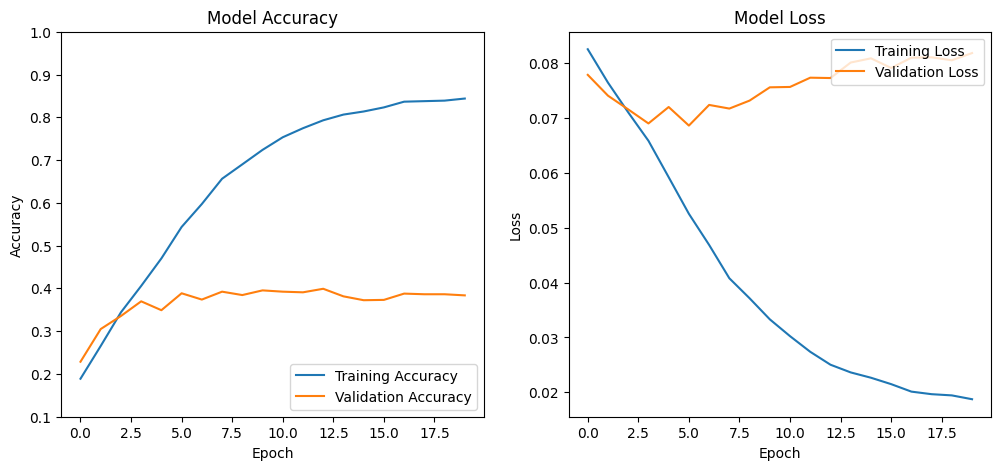

In [17]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_CNN1['custom_accuracy'])
plt.plot(history_CNN1['val_custom_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_CNN1['loss'])
plt.plot(history_CNN1['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')

plt.show()

In [18]:
# Load the best saved model
from keras.models import load_model

model = load_model('CNN_model_1.h5', custom_objects={'custom_loss': custom_loss,'custom_accuracy': custom_accuracy})
# model = load_model('model.h5')
score = model.evaluate(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = model.evaluate(test_generator)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])

166/166 [==============================] - 4s 20ms/step - loss: 0.0686 - custom_accuracy: 0.3886

Val loss: 0.06861109286546707
Val accuracy: 0.3885542154312134
210/210 [==============================] - 5s 21ms/step - loss: 0.0631 - custom_accuracy: 0.4493

Test loss: 0.06309646368026733
Test accuracy: 0.44930553436279297


# Model 1 evaluation

In [35]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

210/210 [==============================] - 4s 21ms/step
Classification Report
                 precision    recall  f1-score   support

          Bread       0.27      0.37      0.31       368
  Dairy product       0.29      0.07      0.11       148
        Dessert       0.45      0.49      0.47       500
            Egg       0.31      0.30      0.30       335
     Fried food       0.32      0.16      0.21       287
           Meat       0.49      0.67      0.57       432
  Noodles-Pasta       0.24      0.04      0.07       147
           Rice       1.00      0.00      0.00        96
        Seafood       0.48      0.40      0.43       303
           Soup       0.58      0.75      0.65       500
Vegetable-Fruit       0.61      0.75      0.68       231

       accuracy                           0.45      3347
      macro avg       0.46      0.36      0.35      3347
   weighted avg       0.44      0.45      0.42      3347



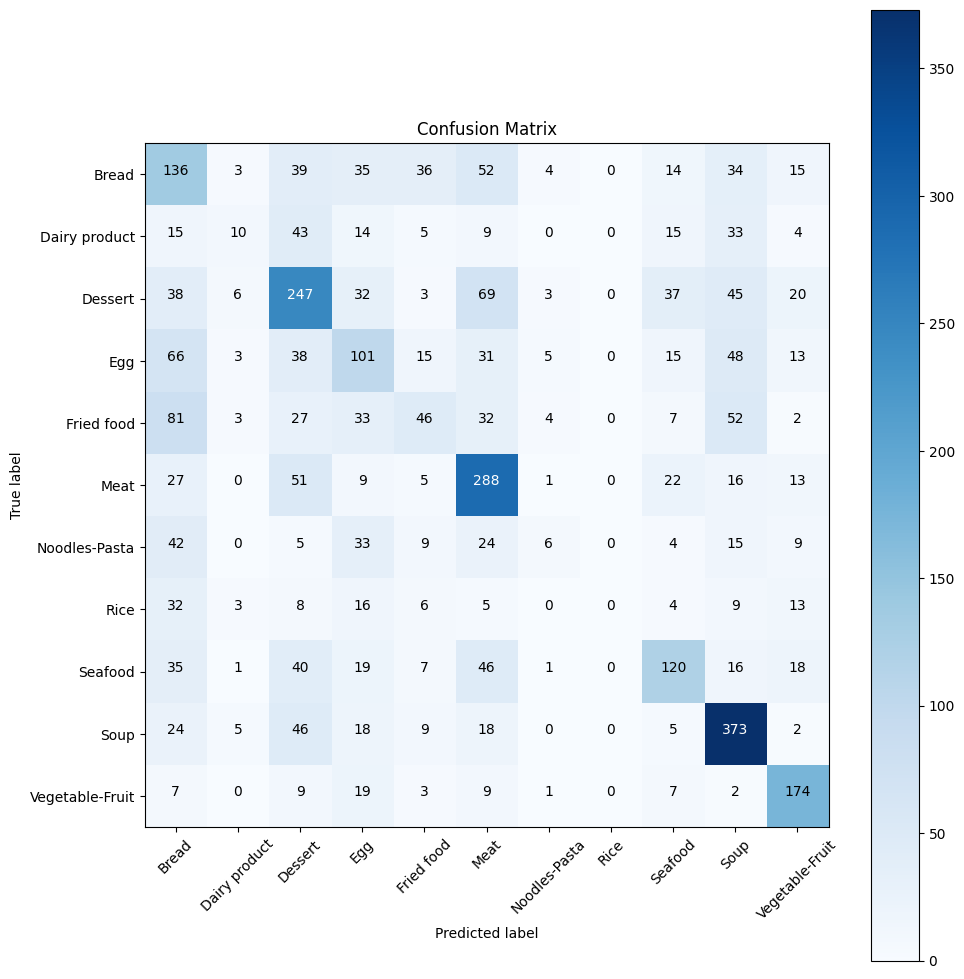

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))

<span style=" font-family: Times New Roman ; font-size: 35px">
    Creating CNN to model2
</span>    

In [10]:
def LeNet_model_2(num_classes=11, model_name="CNN_Model_02"):
    model_2 = Sequential()
    model_2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(im_shape[0], im_shape[1], 3)))
    model_2.add(MaxPooling2D(pool_size=(2, 2)))
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model_2.add(MaxPooling2D(pool_size=(2, 2)))
    model_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model_2.add(MaxPooling2D(pool_size=(2, 2)))
    model_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model_2.add(MaxPooling2D(pool_size=(2, 2)))
    model_2.add(Flatten())
    model_2.add(Dense(100, activation='relu'))
    model_2.add(Dropout(0.2))
    model_2.add(Dense(num_classes, activation='softmax'))
    
    return model_2

# Create the model
model_2 = LeNet_model_2(num_classes=num_classes, model_name="CNN_Model_02")


In [11]:
# Display model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 124, 124, 32)      0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 124, 124, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 59, 59, 64)       

In [12]:
# Compila o modelo
model_2.compile(loss=custom_loss,
              optimizer=Adam(),
              metrics=[custom_accuracy])

In [13]:
import time
# Record the start time of training
start_time = time.time()

<p><li>CNN_model_2.h5 created</li></p>

In [14]:
epochs = 20

#Callback to save the best model
callbacks_list2 = [
    keras.callbacks.ModelCheckpoint(
        filepath='CNN_model_2.h5',
        monitor='val_loss', save_best_only=True, verbose=1)
]

#Training
history2 = model_2.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list2,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/20


2023-12-12 10:03:16.627261: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-12 10:03:18.506982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-12 10:03:20.929938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-12 10:03:21.346139: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fba2c348e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-12 10:03:21.346191: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-12-12 10:03:21.458324: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir

665/665 [==============================] - ETA: 0s - loss: 0.0785 - custom_accuracy: 0.2265
Epoch 1: val_loss improved from inf to 0.07494, saving model to CNN_model_2.h5
665/665 [==============================] - 29s 31ms/step - loss: 0.0785 - custom_accuracy: 0.2265 - val_loss: 0.0749 - val_custom_accuracy: 0.2850
Epoch 2/20
  4/665 [..............................] - ETA: 15s - loss: 0.0766 - custom_accuracy: 0.2500

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


663/665 [============================>.] - ETA: 0s - loss: 0.0743 - custom_accuracy: 0.3056
Epoch 2: val_loss improved from 0.07494 to 0.07154, saving model to CNN_model_2.h5
665/665 [==============================] - 18s 27ms/step - loss: 0.0743 - custom_accuracy: 0.3058 - val_loss: 0.0715 - val_custom_accuracy: 0.3381
Epoch 3/20
663/665 [============================>.] - ETA: 0s - loss: 0.0717 - custom_accuracy: 0.3404
Epoch 3: val_loss improved from 0.07154 to 0.06982, saving model to CNN_model_2.h5
665/665 [==============================] - 18s 27ms/step - loss: 0.0717 - custom_accuracy: 0.3403 - val_loss: 0.0698 - val_custom_accuracy: 0.3562
Epoch 4/20
664/665 [============================>.] - ETA: 0s - loss: 0.0685 - custom_accuracy: 0.3747
Epoch 4: val_loss improved from 0.06982 to 0.06816, saving model to CNN_model_2.h5
665/665 [==============================] - 17s 26ms/step - loss: 0.0684 - custom_accuracy: 0.3748 - val_loss: 0.0682 - val_custom_accuracy: 0.3769
Epoch 5/20
6

In [15]:
# Record the training end time
end_time = time.time()

In [16]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 383.27483201026917 seconds


In [17]:
import pandas as pd
pd.DataFrame(history2.history).head(19)

loss  custom_accuracy  val_loss  val_custom_accuracy
0   0.078472         0.226504  0.074935             0.285015
1   0.074326         0.305827  0.071537             0.338102
2   0.071690         0.340320  0.069819             0.356175
3   0.068444         0.374812  0.068160             0.376883
4   0.064355         0.424342  0.065467             0.406626
5   0.060544         0.465977  0.063308             0.432229
6   0.056889         0.499812  0.062986             0.437500
7   0.053403         0.543421  0.063835             0.436747
8   0.049015         0.583741  0.063858             0.447289
9   0.045692         0.616917  0.063336             0.450301
10  0.042006         0.648496  0.064691             0.449172
11  0.038763         0.680639  0.067897             0.440889
12  0.036632         0.700940  0.068287             0.443901
13  0.033590         0.724060  0.068176             0.445407
14  0.032436         0.734117  0.070670             0.433735
15  0.030478         0.753289  0.071613             0.428840
16  0.028926         0.765696  0.070478             0.447666
17  0.028536         0.768985  0.072105             0.439759
18  0.026304         0.787970  0.072069             0.440889

In [18]:
import joblib

joblib.dump(history2.history,'history_CNN2.pkl')
history_CNN2 = joblib.load('history_CNN2.pkl')

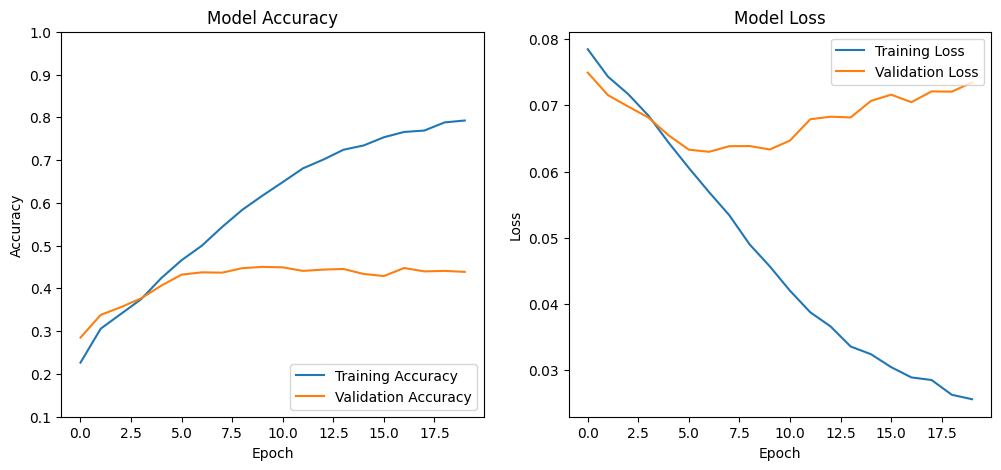

In [19]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_CNN2['custom_accuracy'])
plt.plot(history_CNN2['val_custom_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_CNN2['loss'])
plt.plot(history_CNN2['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')

plt.show()

In [34]:
# Load the best saved model
from keras.models import load_model

model_2 = load_model('CNN_model_2.h5', custom_objects={'custom_loss': custom_loss,'custom_accuracy': custom_accuracy})
# model = load_model('model.h5')
score = model_2.evaluate(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = model_2.evaluate(test_generator)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])

166/166 [==============================] - 3s 20ms/step - loss: 1.6540 - custom_accuracy: 0.4375

Val loss: 1.6539818048477173
Val accuracy: 0.4375
210/210 [==============================] - 4s 21ms/step - loss: 1.5603 - custom_accuracy: 0.4803

Test loss: 1.5602749586105347
Test accuracy: 0.48025792837142944


# Model 2 evaluation

210/210 [==============================] - 5s 21ms/step
Classification Report
                 precision    recall  f1-score   support

          Bread       0.30      0.32      0.31       368
  Dairy product       0.29      0.22      0.25       148
        Dessert       0.41      0.57      0.48       500
            Egg       0.49      0.28      0.36       335
     Fried food       0.41      0.36      0.38       287
           Meat       0.59      0.60      0.59       432
  Noodles-Pasta       0.33      0.55      0.41       147
           Rice       0.00      0.00      1.00        96
        Seafood       0.42      0.38      0.40       303
           Soup       0.64      0.75      0.69       500
Vegetable-Fruit       0.79      0.63      0.70       231

       accuracy                           0.48      3347
      macro avg       0.43      0.42      0.51      3347
   weighted avg       0.47      0.48      0.50      3347



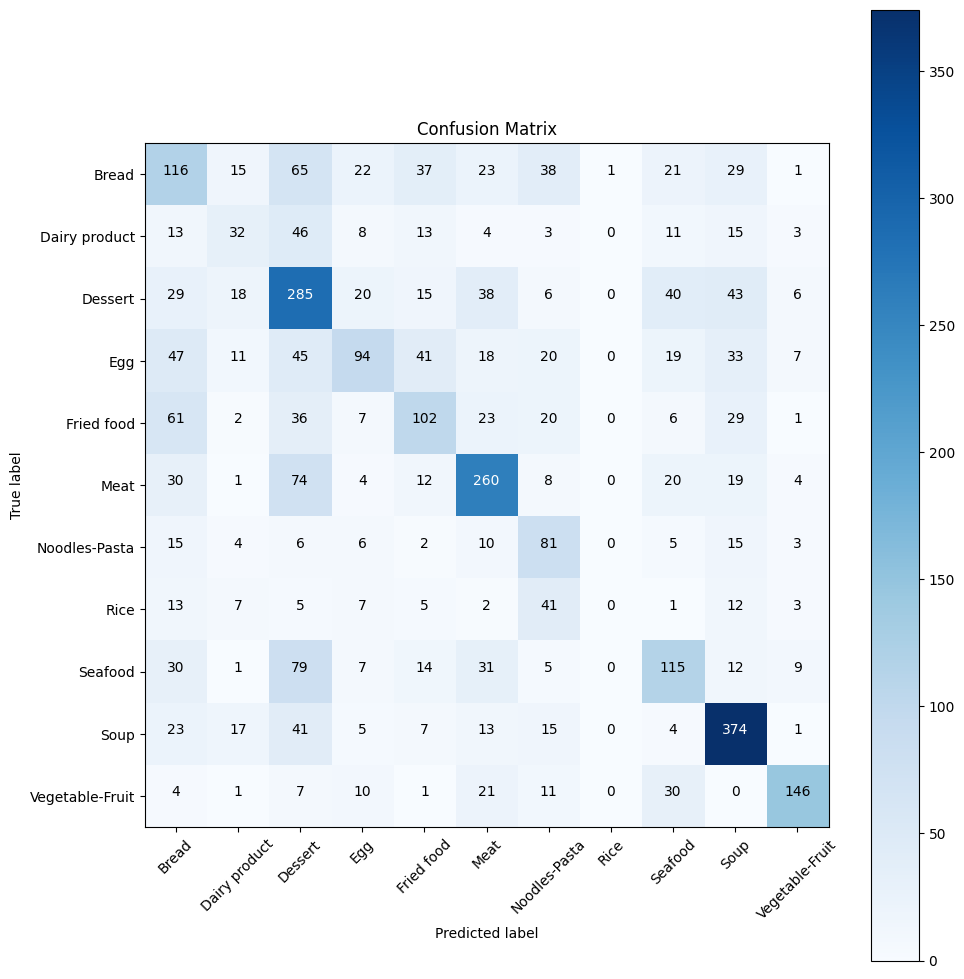

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

#Confution Matrix and Classification Report
Y_pred = model_2.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))

# **Ensemble Module**

- Custom loss and accuracy function

In [20]:
def custom_loss(y_true, y_pred):
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    return loss

def custom_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1)))

In [21]:
from keras.models import load_model
CNN_1 = load_model('CNN_model_1.h5', custom_objects={'custom_loss': custom_loss,'custom_accuracy': custom_accuracy})
CNN_2 = load_model('CNN_model_2.h5', custom_objects={'custom_loss': custom_loss,'custom_accuracy': custom_accuracy})

In [22]:
from tensorflow.keras.regularizers import l2

def build_ensemble_model(models, input_shape, num_classes, ensemble_name):
    # Define input layers
    input_layers = Input(shape=input_shape)

    # Generate output for each model
    output_layers = [model(input_layers) for model in models]

    # Concatenate the model outputs
    ensemble_merge = Concatenate()(output_layers)

    # Apply attention mechanism
    attention = Attention()([ensemble_merge, ensemble_merge])

    # Merge the output of attention with the original ensemble output
    ensemble_attention = Concatenate()([ensemble_merge, attention])

    # Add Batch Normalization for regularization
    ensemble_attention = BatchNormalization()(ensemble_attention)

    # Dense layer after attention with L2 regularization
    ensemble_dense = Dense(100, activation='relu', kernel_regularizer=l2(0.01))(ensemble_attention)
    ensemble_dense = Dropout(0.5)(ensemble_dense)  # Increased dropout rate for more regularization

    # Output layer
    output = Dense(num_classes, activation='softmax')(ensemble_dense)

    # Create the final model
    ensemble_model = Model(inputs=input_layers, outputs=output, name=ensemble_name)

    return ensemble_model


models = [CNN_1, CNN_2]
input_shape = (250, 250, 3)

ensemble_model_1 = build_ensemble_model(models, input_shape, num_classes, ensemble_name='Ensemble_Model')
ensemble_model_1.summary()

Model: "Ensemble_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 11)                   5407195   ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 11)                   2294587   ['input_1[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 22)                   0         ['sequential[0][0]',          
                                                                     'sequential_1[0]

In [24]:
ensemble_model_1.compile(loss=custom_loss,
              optimizer=Adam(),
              metrics=[custom_accuracy])

In [25]:
print(ensemble_model_1)

In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

epochs = 50

#Callback to save the best model
callbacks_list3 = [
    ModelCheckpoint(
        filepath='Ensemble_Model_1.h5',
        monitor='val_loss', save_best_only=True, verbose=1)
]

#Training
history3 = ensemble_model_1.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list3,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/50


2023-12-12 10:10:23.067684: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEnsemble_Model/sequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


665/665 [==============================] - ETA: 0s - loss: 1.7557 - custom_accuracy: 0.5424
Epoch 1: val_loss improved from inf to 1.44398, saving model to Ensemble_Model_1.h5
665/665 [==============================] - 22s 26ms/step - loss: 1.7557 - custom_accuracy: 0.5424 - val_loss: 1.4440 - val_custom_accuracy: 0.5960
Epoch 2/50


/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


663/665 [============================>.] - ETA: 0s - loss: 1.2342 - custom_accuracy: 0.6515
Epoch 2: val_loss improved from 1.44398 to 0.92241, saving model to Ensemble_Model_1.h5
665/665 [==============================] - 17s 26ms/step - loss: 1.2343 - custom_accuracy: 0.6514 - val_loss: 0.9224 - val_custom_accuracy: 0.7252
Epoch 3/50
663/665 [============================>.] - ETA: 0s - loss: 1.0566 - custom_accuracy: 0.6916
Epoch 3: val_loss improved from 0.92241 to 0.89623, saving model to Ensemble_Model_1.h5
665/665 [==============================] - 19s 28ms/step - loss: 1.0567 - custom_accuracy: 0.6914 - val_loss: 0.8962 - val_custom_accuracy: 0.7372
Epoch 4/50
664/665 [============================>.] - ETA: 0s - loss: 0.9136 - custom_accuracy: 0.7323
Epoch 4: val_loss did not improve from 0.89623
665/665 [==============================] - 18s 26ms/step - loss: 0.9133 - custom_accuracy: 0.7324 - val_loss: 1.0964 - val_custom_accuracy: 0.7067
Epoch 5/50
665/665 [==================

In [27]:
import pandas as pd
pd.DataFrame(history3.history)

loss  custom_accuracy  val_loss  val_custom_accuracy
0   1.755746         0.542387  1.443983             0.596009
1   1.234287         0.651410  0.922409             0.725151
2   1.056692         0.691353  0.896227             0.737199
3   0.913317         0.732425  1.096427             0.706702
4   0.836438         0.760432  0.766177             0.783886
5   0.756654         0.782331  0.948027             0.760542
6   0.671242         0.809868  0.760828             0.800075
7   0.617679         0.823966  0.877707             0.787274
8   0.574152         0.837970  0.997727             0.760919
9   0.558033         0.838252  1.172051             0.742093
10  0.505012         0.855169  0.853448             0.807229
11  0.497120         0.860526  1.005264             0.769202
12  0.455085         0.874154  1.197104             0.728163
13  0.437618         0.875564  1.155564             0.763931
14  0.432262         0.879793  1.139763             0.751883
15  0.414024         0.880357  0.938772             0.788027
16  0.401787         0.888064  1.106532             0.785015
17  0.389435         0.888064  0.962838             0.800075
18  0.396311         0.887500  1.256724             0.769202
19  0.356765         0.899060  0.807097             0.810994
20  0.348172         0.901598  1.503621             0.750753
21  0.357059         0.901128  1.230371             0.775602
22  0.347367         0.904887  0.906530             0.802711
23  0.348752         0.899248  0.882475             0.800075
24  0.332066         0.906861  0.879219             0.806099
25  0.347181         0.902820  1.035779             0.789910
26  0.315989         0.913440  0.825131             0.834714
27  0.324199         0.909211  1.363570             0.756401
28  0.299753         0.916353  0.882852             0.829443
29  0.312745         0.912030  0.779754             0.817395
30  0.306086         0.912500  0.997093             0.804970
31  0.289488         0.916917  0.997616             0.788780
32  0.284120         0.918797  0.889428             0.813253
33  0.315212         0.911842  0.898078             0.816642
34  0.291731         0.916447  0.978155             0.764307
35  0.294485         0.915132  1.163179             0.780873
36  0.292403         0.920395  1.128142             0.789157
37  0.282333         0.915977  1.197415             0.760542
38  0.266613         0.923308  1.120608             0.777485
39  0.252532         0.931109  1.420136             0.767696
40  0.285538         0.921523  0.943614             0.800828
41  0.268395         0.922274  1.037375             0.792169
42  0.273969         0.918609  1.738387             0.694277
43  0.263810         0.925376  1.369572             0.761295
44  0.265311         0.923778  1.157729             0.795181
45  0.243958         0.929887  1.157038             0.778614
46  0.248827         0.926316  1.064262             0.786145
47  0.246285         0.928101  1.185809             0.791416
48  0.263352         0.924342  1.143697             0.780497
49  0.264703         0.924718  1.203247             0.771084

In [28]:
import joblib
joblib.dump(history3.history,'history3.pkl')

['history3.pkl']

In [29]:
history_3 = joblib.load('history3.pkl')

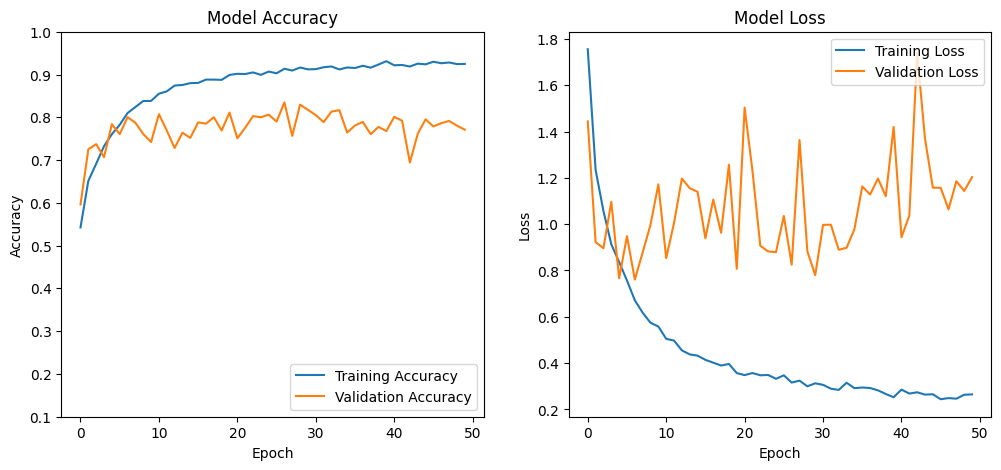

In [30]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_3['custom_accuracy'])
plt.plot(history_3['val_custom_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_3['loss'])
plt.plot(history_3['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')

plt.show()

In [31]:
model_3 = load_model('Ensemble_Model_1.h5', custom_objects={'custom_loss': custom_loss,'custom_accuracy': custom_accuracy})

score = model_3.evaluate(test_generator)
test_loss.append(score[0])
test_accuracy.append(score[1])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

210/210 [==============================] - 4s 20ms/step - loss: 0.4168 - custom_accuracy: 0.8961
Test loss: 0.4167579412460327
Test accuracy: 0.8961309790611267


In [32]:
score = model_3.evaluate(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('Val loss:', score[0])
print('Val accuracy:', score[1])

166/166 [==============================] - 4s 23ms/step - loss: 0.7608 - custom_accuracy: 0.8001
Val loss: 0.7608280777931213
Val accuracy: 0.8000752925872803


# Ensembel_Model evaluation

210/210 [==============================] - 5s 22ms/step
Classification Report
                 precision    recall  f1-score   support

          Bread       0.95      0.80      0.87       368
  Dairy product       0.85      0.43      0.57       148
        Dessert       0.82      0.94      0.88       500
            Egg       0.84      0.94      0.88       335
     Fried food       0.92      0.93      0.92       287
           Meat       0.98      0.96      0.97       432
  Noodles-Pasta       0.68      0.97      0.80       147
           Rice       0.89      0.26      0.40        96
        Seafood       0.95      0.92      0.93       303
           Soup       0.95      0.99      0.97       500
Vegetable-Fruit       0.96      0.99      0.97       231

       accuracy                           0.90      3347
      macro avg       0.89      0.83      0.83      3347
   weighted avg       0.90      0.90      0.89      3347



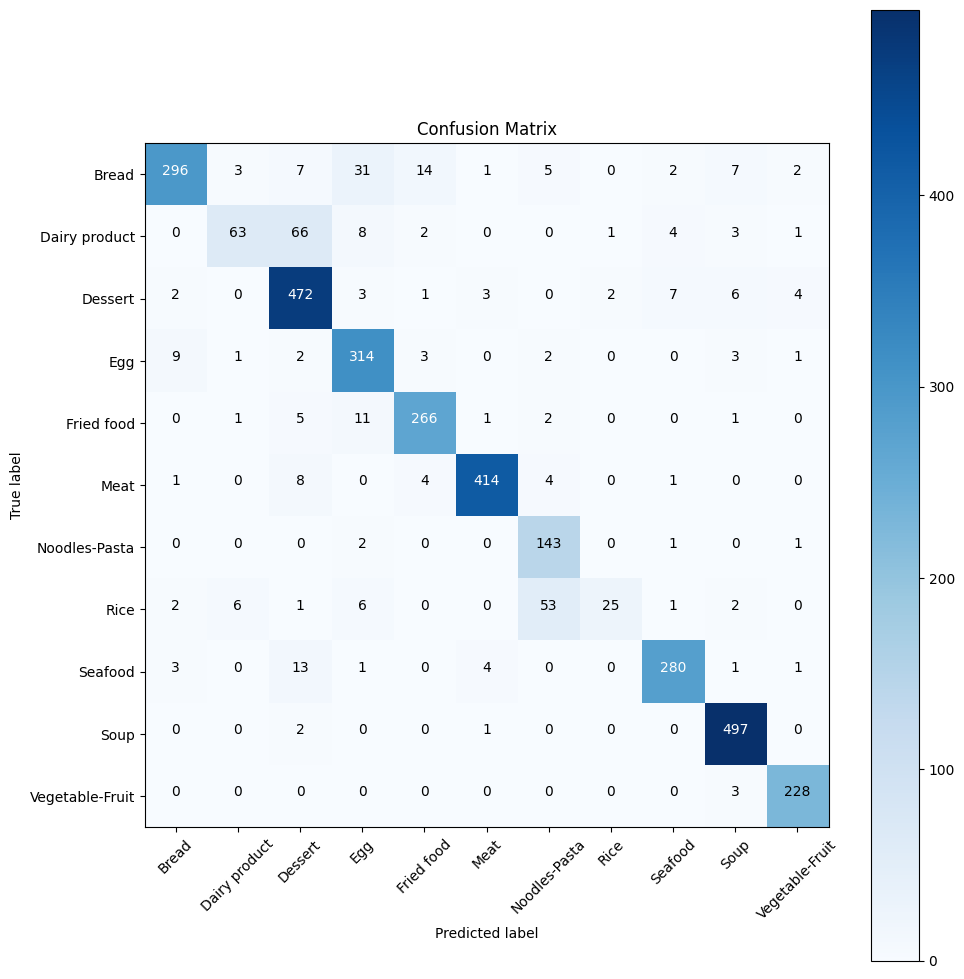

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model_3.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names,zero_division=1))

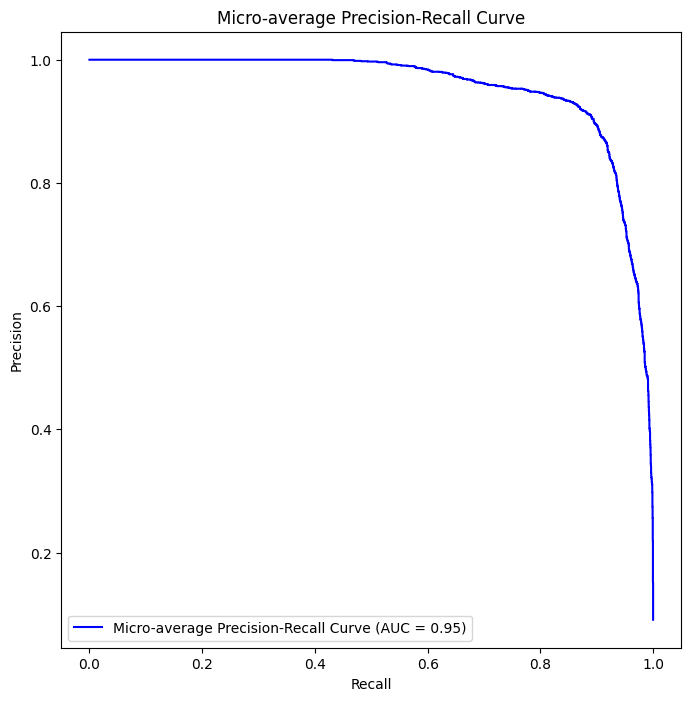

In [38]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# Precision-Recall Curve for each class
n_classes = len(classes)
y_true_bin = label_binarize(test_generator.classes, classes=list(range(n_classes)))
precision = dict()
recall = dict()
auc_score = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], Y_pred[:, i])
    auc_score[i] = auc(recall[i], precision[i])

# Micro-average precision-recall curve and AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), Y_pred.ravel())
auc_score["micro"] = auc(recall["micro"], precision["micro"])

# Plot micro-average Precision-Recall Curve
plt.figure(figsize=(8, 8))
plt.plot(recall["micro"], precision["micro"], label=f'Micro-average Precision-Recall Curve (AUC = {auc_score["micro"]:.2f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-average Precision-Recall Curve')
plt.legend()
plt.show()

In [39]:
#Generate predictions for the test dataset
y_pred = model_3.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

210/210 [==============================] - 5s 21ms/step


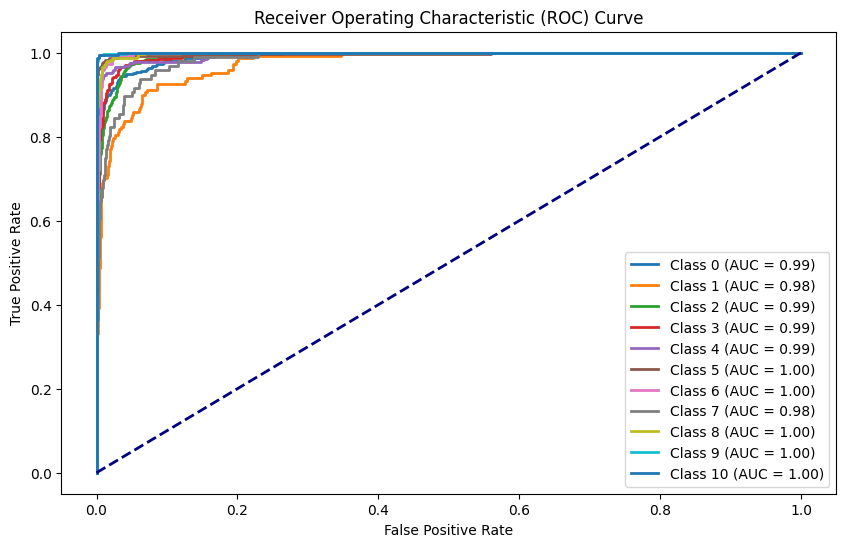

In [40]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc


#Get the true labels from thee test generator
# y_true = test_generator.classes
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Initialize arrays to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import numpy as np
# Initialize the list of Sensitivity and Specificity for each class
sensitivity_list = []
specificity_list = []

# The Sensitivity and Specificity of each class were calculated
for i in range(len(cm)):
    tp = cm[i, i]  # True Positive
    fn = np.sum(cm[i, :]) - tp  # False Negative
    fp = np.sum(cm[:, i]) - tp  # False Positive
    tn = np.sum(cm) - (tp + fn + fp)  # True Negative
    
    sensitivity = tp / (tp + fn + 1e-10)  # Add a small number to avoid dividing by zero
    specificity = tn / (tn + fp + 1e-10)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

# Output Sensitivity and Specificity for each category
for idx, (sen, spec) in enumerate(zip(sensitivity_list, specificity_list)):
    print(f"Class {idx} - Sensitivity: {sen}, Specificity: {spec}")


Class 0 - Sensitivity: 0.8043478260867379, Specificity: 0.9942933870425984
Class 1 - Sensitivity: 0.4256756756753881, Specificity: 0.9965614254454206
Class 2 - Sensitivity: 0.9439999999998112, Specificity: 0.9634703196346693
Class 3 - Sensitivity: 0.9373134328355411, Specificity: 0.9794156706506979
Class 4 - Sensitivity: 0.92682926829236, Specificity: 0.9921568627450656
Class 5 - Sensitivity: 0.9583333333331115, Specificity: 0.9965694682675472
Class 6 - Sensitivity: 0.9727891156455968, Specificity: 0.9793749999999694
Class 7 - Sensitivity: 0.2604166666663954, Specificity: 0.9990772070131959
Class 8 - Sensitivity: 0.9240924092406192, Specificity: 0.9947437582128451
Class 9 - Sensitivity: 0.9939999999998013, Specificity: 0.9908675799086409
Class 10 - Sensitivity: 0.9870129870125598, Specificity: 0.996790757381226


In [42]:
# Evaluate the performance of the model
evaluate = model_3.evaluate(
    test_generator, 
    steps = test_generator.n // BATCH_SIZE, 
    verbose = 1
)

print('Accuracy Test : {}'.format(evaluate[1]))

209/209 [==============================] - 5s 22ms/step - loss: 0.4171 - custom_accuracy: 0.8956
Accuracy Test : 0.8956339955329895


1/1 [==============================] - 0s 137ms/step


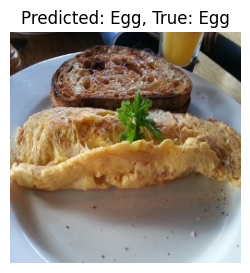

1/1 [==============================] - 0s 21ms/step


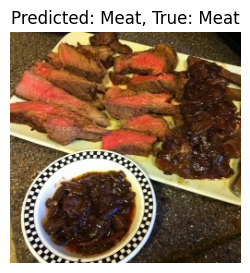

1/1 [==============================] - 0s 18ms/step


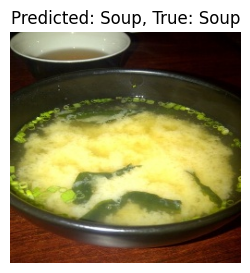

1/1 [==============================] - 0s 17ms/step


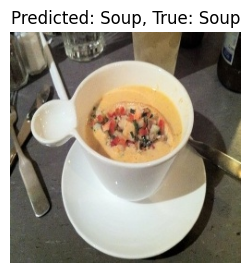

1/1 [==============================] - 0s 17ms/step


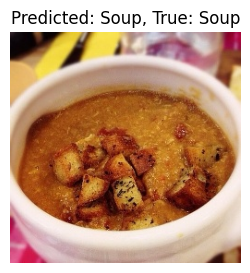

1/1 [==============================] - 0s 18ms/step


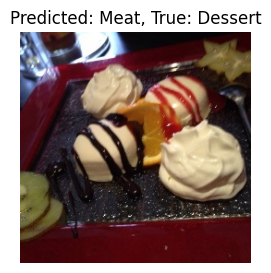

1/1 [==============================] - 0s 18ms/step


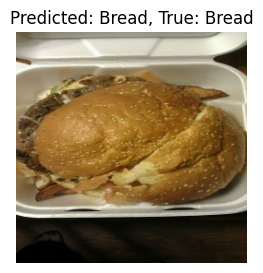

1/1 [==============================] - 0s 17ms/step


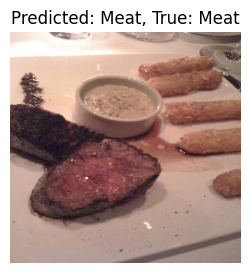

1/1 [==============================] - 0s 18ms/step


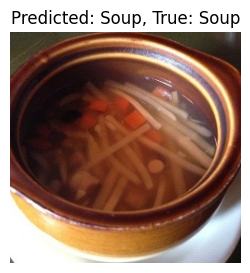

1/1 [==============================] - 0s 17ms/step


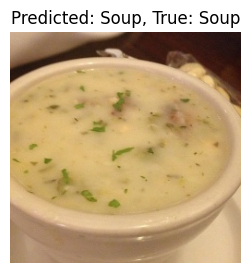

In [43]:
from keras.preprocessing import image as keras_image
# 10 images are randomly selected
random_indices = np.random.choice(len(test_generator.filenames), size=10, replace=False)

model_3 = load_model('Ensemble_Model_1.h5', custom_objects={'custom_loss': custom_loss,'custom_accuracy': custom_accuracy})

for idx in random_indices:
    img_path = test_generator.filepaths[idx]

    # Load and preprocess images
    img = keras_image.load_img(img_path, target_size=(250, 250))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make model prediction
    predictions = model_3.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Get real tags
    true_label = test_generator.classes[idx]

    # Visualizations and results
    class_names = list(test_generator.class_indices.keys())

    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_names[predicted_class]}, True: {class_names[true_label]}")
    plt.show()

<span style=" font-family: Times New Roman ; font-size: 35px">
The performance results of the three models are compared
</span>

In [5]:
import seaborn as sns

date_results={
    "Val_loss":[0.068,1.65,0.76],
    "Val_accuracy":[0.38,0.43,0.80],
    "Test_loss":[0.063,1.56,0.41],
    "Test_accuracy":[0.44,0.48,0.89],
    "Model":['CNN1','CNN2','Ensemble_CNN']}

date_result=pd.DataFrame(date_results)
date_result2 = date_result.iloc[:3,:4]
date_result3 = pd.concat([date_result2,date_result['Model']],axis=1)
date_result3.head()

Val_loss  Val_accuracy  Test_loss  Test_accuracy         Model
0     0.068          0.38      0.063           0.44          CNN1
1     1.650          0.43      1.560           0.48          CNN2
2     0.760          0.80      0.410           0.89  Ensemble_CNN

<span style=" font-family: Times New Roman ; font-size: 25px">
    Now we can see the Difference between CNNs and Ensemble CNN
</span>

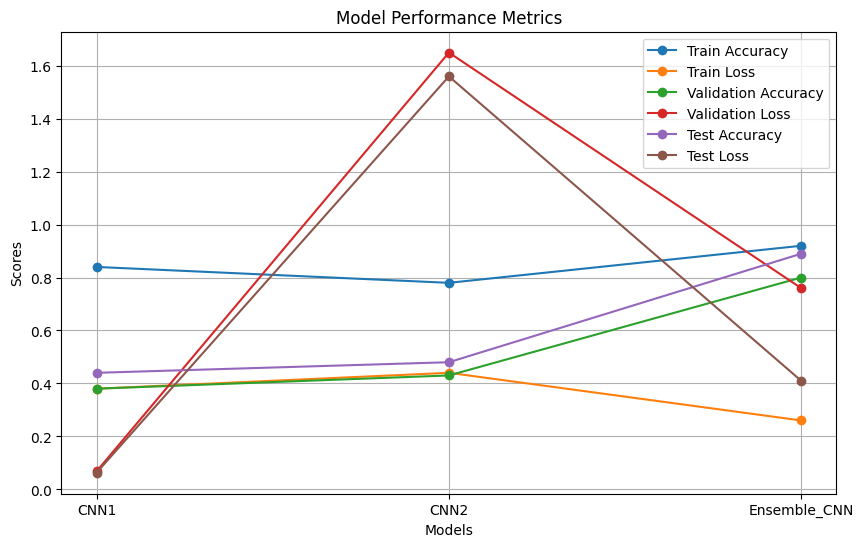

In [13]:
date_results = {
    "Train_accuracy": [0.84, 0.78, 0.92],
    "Train_loss": [0.38, 0.44, 0.26],
    "Val_loss": [0.068, 1.65, 0.76],
    "Val_accuracy": [0.38, 0.43, 0.80],
    "Test_loss": [0.063, 1.56, 0.41],
    "Test_accuracy": [0.44, 0.48, 0.89],
    "Model": ['CNN1', 'CNN2', 'Ensemble_CNN']
}

models = date_results["Model"]
train_accuracy = date_results["Train_accuracy"]
train_loss = date_results["Train_loss"]
val_loss = date_results["Val_loss"]
val_accuracy = date_results["Val_accuracy"]
test_loss = date_results["Test_loss"]
test_accuracy = date_results["Test_accuracy"]

plt.figure(figsize=(10, 6))

plt.plot(models, train_accuracy, marker='o', label='Train Accuracy')
plt.plot(models, train_loss, marker='o', label='Train Loss')
plt.plot(models, val_accuracy, marker='o', label='Validation Accuracy')
plt.plot(models, val_loss, marker='o', label='Validation Loss')
plt.plot(models, test_accuracy, marker='o', label='Test Accuracy')
plt.plot(models, test_loss, marker='o', label='Test Loss')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model

In [ ]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()